### Introduction to Hydro, etc...

### Introduction to Bayes THM, etc...

## Defining our physics model

We will use a linear model for the hydrodynamic response of the elliptic flow $v_2$ to the specific shear viscosity $\eta/s$.

Ordinarily we would use a hydrodynamic simulation to model the physics, but we use a linear-model in this notebook because its not computationally demanding, allowing us to focus on concepts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#sns.set_context('talk')
import time

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.preprocessing import StandardScaler

import emcee
import corner

In [2]:
#Our linear model for hydrodynamic response
#note output in some centrality bin, for example 20-30%

#noise level controls statistical scatter in our physics model
noise = 0.1 #amount of statistical scatter in our training calculations

#this function will play the role of a realistic event-by-event hydrodynamic model
def lin_hydro_model(eta_over_s, intercept = 0.12, slope = -0.25, noise = 0.05): 
    y = intercept + slope * (eta_over_s) # the mean model prediction
    dy = noise * y * np.random.normal() #the model stat error
    y += dy # add the model stat. error to the model mean
    y = np.max([0., y]) #suppose our measurement definition is positive definite
    return y, dy

lin_hydro_model = np.vectorize(lin_hydro_model)

### Training our Emulator

Normally, a real hydrodynamic physics model could take hours to run a single event, and we may need thousands of events to construct a centrality average. Therefore, for computationally demanding models we can employ a fast surrogate (interpolation) which can estimate the interpolation uncertainty. We can use a Gaussian Process!

We will first train our Gaussian Process by running our physics simulation on a sampling of points that fill our parameter space...

/Users/derek/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()


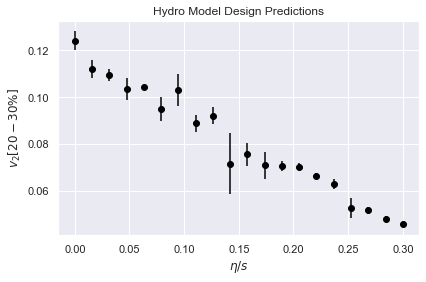

In [3]:
n_design_pts = 20 # this sets the number of design points where we will run our hydro model
eta_over_s_min = 0. # this defines a minmum value for eta/s
eta_over_s_max = 0.3 # this defines a maximum value for eta/s

model_X = np.linspace(eta_over_s_min, eta_over_s_max, n_design_pts).reshape(-1,1)

#these are the v_2 outputs of our hydro model, assuming that the model has finite statistical error
model_y, model_dy = lin_hydro_model(model_X)

#lets plot our physics models predictions
plt.errorbar(model_X, model_y, model_dy, fmt='o', c='black')
plt.xlabel(r'$\eta/s$')
plt.ylabel(r'$v_2 [ 20-30\%]$')
plt.title('Hydro Model Design Predictions')
plt.tight_layout(True)
plt.show()

### Now, we want a fast and accurate non-parametric interpolation of our physics model which can estimate interpolation uncertainty.
We will use a Gaussian process (https://en.wikipedia.org/wiki/Gaussian_process).

For an intuitive feeling for how they work, play with this widget http://www.tmpl.fi/gp/.
For more details see http://www.gaussianprocess.org/gpml/chapters/RW.pdf.

We will use the Squared Exponential Kernel in this exercise

(formula...)

We give scikit learn the GP kernel that we want to use, and some guidance for the hyperparameters, and then when we fit the GP, scikit-learn automatically finds the values of hyperparameters that maximize a likelihood function:

(formula...)

Note, the second term penalizes overfitting. 

In [4]:
#this is the 'size' of possible variation of our parameters, in this case eta/s
ptp = max(model_X) - min(model_X)

#This is our Squared Exponential Kernel
rbf_kern = 1. * kernels.RBF(
                      length_scale=ptp,
                      length_scale_bounds=np.outer(ptp, (1e-2, 1e2)),
                      )
#This is a white noise kernel, 
#necessary because our physics model has finite statistical accuracy
white_kern = kernels.WhiteKernel(
                         noise_level=.1,
                         noise_level_bounds=(1e-2, 1e1)
                        )

#our kernel is the sum of the Sq. Exponential and White Noise kernels
my_kernel = (rbf_kern + white_kern) 

As with many machine learning toolkits, out-of-the-box performance is often best when we first scale our outputs. The 'Standard Scaler' (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) is convenient for this purpose.

In [5]:
model_y_copy = model_y.copy()
scaler = StandardScaler(copy=True).fit(model_y_copy)
scaled_model_y = scaler.transform(model_y, copy=True) # the scaled model outputs

### Training our GP on the hydro model calculations

In [6]:
#maximizing the GP likelihood proceeds in an iterative process,
#beginning with a random seed. We want to be sure we find a global max.,
#so we restart it several times
nrestarts=10

#define our Gaussian process, and fit it to the hydro model calculations
my_gp = GPR(kernel=my_kernel,
         alpha=0.01, # the nugget, to stabilize matrix inversions
         n_restarts_optimizer=nrestarts, 
         ).fit(model_X, scaled_model_y)

In [7]:
#Convenient to define a function that handles the scaling and 
#interpolation together, returning our prediction in the ordinary observable space
#rather than the scaled observable space
#This map is what we call our 'emulator'
def emu_predict(eta_over_s):
    X = eta_over_s.reshape(-1, 1)
    scaled_y, scaled_dy = my_gp.predict(X, return_std=True)
    y = scaler.inverse_transform(scaled_y).reshape(len(eta_over_s))
    dy = scaled_dy * scaler.scale_
    return y, dy

### Let's check how our GP emulator fits the hydro physics model

/Users/derek/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':


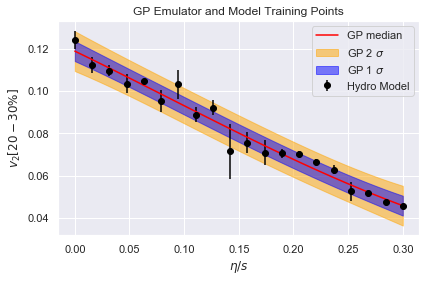

In [8]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
gp_X_plot = np.linspace(eta_over_s_min, eta_over_s_max, n_plot_pts)

gp_y, gp_dy = emu_predict(gp_X_plot)

plt.plot(gp_X_plot, gp_y, color='red', label='GP median')
plt.fill_between(gp_X_plot, y1 = gp_y - 2.*gp_dy, y2 = gp_y + 2.*gp_dy, 
                 interpolate=True, alpha=0.5, label=r'GP 2 $\sigma$', color='orange')
plt.fill_between(gp_X_plot, y1 = gp_y - gp_dy, y2 = gp_y + gp_dy, 
                 interpolate=True, alpha=0.5, label=r'GP 1 $\sigma$', color='blue')
plt.errorbar(model_X, model_y, model_dy, fmt='o', c='black', label='Hydro Model')

plt.xlabel(r'$\eta/s$')
plt.ylabel(r'$v_2 [ 20-30\%]$')
plt.title('GP Emulator and Model Training Points')
plt.legend()
plt.tight_layout(True)
plt.show()

### Certainly we would expect our emulator to fit well the points on which it was trained...
Ultimately, we want to know if our emulator can be trusted for points in parameter space in which it was **not trained**. 

So, let's perform a validation, using a novel testing set of model calculations...


In [9]:
#this defines a new set of points in parameter space where we will run our model
n_test_pts = 15
model_X_test = np.random.uniform(eta_over_s_min, eta_over_s_max, n_test_pts).reshape(-1,1)
#get the hydro model predictions for these points
model_y_test, model_dy_test = lin_hydro_model(model_X_test)

#Now use the emulator trained on the original training points to predict
#outputs on this testing set
gp_y_test, gp_dy_test = emu_predict(model_X_test)

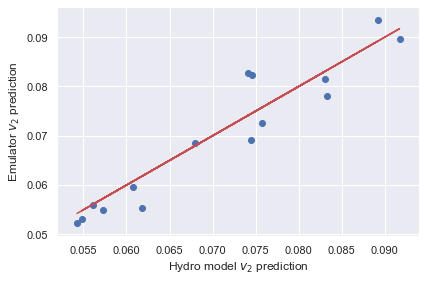

In [10]:
#Plot the emulator prediction vs the hydro model prediction
plt.xlabel(r'Hydro model $v_2$ prediction')
plt.ylabel(r'Emulator $v_2$ prediction')
plt.plot(model_y_test, model_y_test, color='r')
plt.scatter(model_y_test, gp_y_test)
plt.tight_layout(True)
plt.show()

### This looks pretty good. There are stricter tests we can make to check if the prediction is biased...

If $\hat{y}(\theta)$ is our emulator prediction for the parameters $\theta$, and $y(\theta)$ is our hydro model prediction, we can call the 'residual' $\hat{y}(\theta) - y(\theta)$

Let's plot the residual as a function of $\eta/s$...

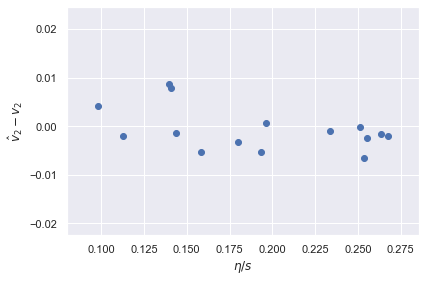

In [12]:
model_y_test = model_y_test.reshape(n_test_pts)
res = gp_y_test - model_y_test
plt.scatter(model_X_test, res)
plt.xlabel(r'$\eta/s$')
plt.ylabel(r'$\hat{v}_2 - v_2$')
plt.tight_layout(True)
plt.show()

By inspection, it doesn't look like our emulator has signficant bias for any value of $\eta/s$, which is good. They are even more illuminating tests one can make, for example Quantile-Quantile plots (https://en.wikipedia.org/wiki/Q–Q_plot), etc... 

### Now, we have a fast and accurate surrogate that we can trust to compare to data anywhere in the parameter space 

So we want to use our emulator to perform **Bayesian inference**.

Recall, that our **posterior** $p(\theta|D)$ of our parameters $\theta$ given the observed experimental data $D$ is the product of our **prior** belief about the parameters $p(\theta)$ and the **likelihood** $p(D|\theta)$ of observing those experimental data given the true value of the parameters is $\theta$. This is Bayes THM:

$$p(\theta|D) \propto p(D|\theta)p(\theta)$$

So, before using experimental data to update our belief about $\eta/s$, we need to define our prior belief about $\eta/s$.

In [13]:
#define two different priors, one more informed than the other
theta_min = eta_over_s_min
theta_max = eta_over_s_max

#a flat prior
def log_flat_prior(theta):
    """Flat prior on value between limits"""
    if (theta_min < theta) and (theta < theta_max):
        return 0. # log(1)
    else:
        return -np.inf  # log(0)
    
#a peaked prior
prior_peak = 3. / (4. * np.pi) # the value of eta/s we belief most likely, before seeing data
prior_width = 1. / (4. * np.pi) #our uncertainty about this value, before seeing the data
def log_peaked_prior(theta):
    """Flat prior on value between limits"""
    if (theta_min < theta) and (theta < theta_max):
        return -0.5 * (theta - prior_peak)**2. / prior_width**2. 
    else:
        return -np.inf  # log(0)

### To compare our model predictions with experiment, we need to define our likelihood function
The likelihood is a model for the conditional probability of observing the data given some true value of the parameters. Specifically,
the probability of observing some experimental value for $v_2$ given some value of $\eta/s$.

A commonplace assumption is to assume that the experimental errors follow a multivariate Gaussian distribution. This assumption is also the distribution which maximizes the information entropy subject to the constraints being normalizable, having a known mean, and a known variance...
This can be derived using the method of Lagrange multipliers. For details see (https://github.com/furnstahl/Physics-8805/blob/master/topics/maximum-entropy/MaxEnt.ipynb). 

In [14]:
def log_likelihood(theta, y_exp, dy_exp):
    #use our GP emulator to approximate the hydro model
    y_pred, dy_pred = emu_predict(theta) # emulation prediction and uncertainty
    dy_tot = np.sqrt( dy_pred**2. + dy_exp**2. ) #total uncertainty, emulation and exp.
    return -0.5 * np.sum( (y_pred - y_exp)**2 / dy_tot**2 )

In [15]:
#posterior using flat prior
def log_posterior_1(theta, y_exp, dy_exp):
    '''Log posterior for data X given parameter array theta'''
    return log_flat_prior(theta) + log_likelihood(theta, y_exp, dy_exp)

#posterior using peaked prior
def log_posterior_2(theta, y_exp, dy_exp):
    '''Log posterior for data X given parameter array theta'''
    return log_peaked_prior(theta) + log_likelihood(theta, y_exp, dy_exp)

### Now, we want to infer the physical value of $\eta/s$ by using some experimental data

Suppose that an experiment measures $v_2[20-30\%]$, and is reported by a mean value and total uncertainty...

In [16]:
exp_rel_uncertainty = 0.1 # experimental relative uncertainty
y_exp = 0.09 #v_2 experimental mean
dy_exp = y_exp * exp_rel_uncertainty #v_2 experimental uncertainty

Although our current problem is much-simplified by the use of a linear model, in general we will have no analytic expression for our likelihood function. In this case, one needs a set of numerical tools which can approximate the likelihood function. 

In addition, for many problems of interest our parameter space can be highly dimensional, so these methods need to work well for high-dimensional problems...

We solve both of these problems by employing Markov Chain Monte Carlo sampling (http://www.columbia.edu/~mh2078/MachineLearningORFE/MCMC_Bayes.pdf).

Specifically, we will use a python implementation called *Emcee* (https://emcee.readthedocs.io/en/stable/), which will work well for our purposes...

In [17]:
ndim = 1  # number of parameters in the model
nwalkers = 20*ndim  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations within the prior volume
starting_guesses = theta_min + \
                   (theta_max - theta_min) * np.random.rand(nwalkers,ndim)

print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_1, args=[y_exp, dy_exp])

# "burn-in" period; save final positions and then reset
pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
sampler.reset()

# sampling period
sampler.run_mcmc(pos, nsteps)

print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                .format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))

# discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
samples = sampler.chain.reshape((-1, ndim))

MCMC sampling using emcee (affine-invariant ensamble sampler) with 20 walkers
Mean acceptance fraction: 0.807 (in total 40000 steps)


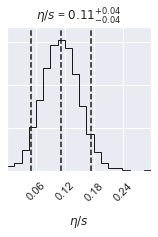

In [18]:
# make a corner plot with the posterior distribution
fig = corner.corner(samples, labels=["$\eta/s$"],
                    quantiles=[0.05, 0.5, 0.95],
                    show_titles=True, title_kwargs={"fontsize": 12})
#plt.suptitle('Posterior of Specific Shear Viscosity')
#plt.tight_layout(True)
plt.show()